#### ÏûëÏóÖ ÎÖ∏Ìä∏Î∂Å 
- feature Ï†ïÎ¶¨ 
- Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
- Î™®Îç∏ÎßÅ
- ÌïôÏäµ Î∞è Ï∂îÎ°†
- Ï†úÌíàÎ≥Ñ Ï∂îÏ≤ú Í≤∞Í≥º ÌÖåÏù¥Î∏î

In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install sqlalchemy
%pip install pymysql
%pip install konlpy
%pip install matplotlib
%pip install gensim
%pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import warnings
import re 
from model.bow import BagOfWords
from model.tfidf import TfIdf
import yaml
import matplotlib.pyplot as plt

from utils.preprocessing import *

warnings.filterwarnings("ignore")

#### Configuration
- Ï∂îÏ≤ú ÏÑúÎπÑÏä§ ÏÉùÏÑ±ÏùÑ ÏúÑÌï¥ÏÑú ÌïÑÏöîÌïú ÏÑ§Ï†ïÍ∞íÎì§ÏùÑ ÏÑ∏ÌåÖÌï©ÎãàÎã§.

In [2]:
# config
with open('configs/database.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
from utils.query_service import QueryService
query_service = QueryService(cfg['mysql'])

#### Data Import
- ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞Î•º mysqlÏóêÏÑú Í∞ÄÏ†∏ÏòµÎãàÎã§. 

In [4]:
query_service.query_to_pandas_df('Show tables')

Tables_in_bakery
0   board_preference_statistic
1              board_statistic
2                  food_survey
3                        image
4                       member
5            member_preference
6                       notice
7                   preference
8                      product
9                product_board
10              product_detail
11                 product_img
12                        push
13                   push_date
14                random_board
15               refresh_token
16                      review
17                  review_img
18                 review_like
19                      search
20         signature_agreement
21                       store
22                  test_store
23             wishlist_folder
24            wishlist_product
25              wishlist_store
26                  withdrawal

In [5]:
PRODUCT_BOARD_SQL = """
SELECT id
, store_id
, title
, price
, is_soldout
, view 
FROM product_board
"""
product_board = query_service.query_to_pandas_df(PRODUCT_BOARD_SQL)

In [6]:
PRODUCT_SQL = """
SELECT id
, product_board_id
, title as option
, price as option_price
, category
, gluten_free_tag
, high_protein_tag
, sugar_free_tag
, vegan_tag
, ketogenic_tag
FROM product
"""
product = query_service.query_to_pandas_df(PRODUCT_SQL)

In [7]:
REVIEW_SQL = """
SELECT board_id
, badge_taste
, badge_brix
, badge_texture
, rate
, content
FROM review
"""
review = query_service.query_to_pandas_df(REVIEW_SQL)
review = review.drop_duplicates(subset=['board_id', 'content'], keep='first')

In [8]:
BOARD_STAT_SQL = """
SELECT board_id
, board_review_grade
, board_view_count
, board_review_count
, board_wish_count 
FROM board_statistic
"""
board_stat = query_service.query_to_pandas_df(BOARD_STAT_SQL)

In [9]:
# board_idÍ∞Ä Í∞Å preference_typeÎßàÎã§ ÏñºÎßåÌÅºÏùò preference_scoreÎ•º Í∞ñÎäîÏßÄ
# ÏïÑÏßÅ Ïã†Î¢∞ÏÑ±ÏûàÎäî Îç∞Ïù¥ÌÑ∞Î°ú Î≥¥Ïù¥ÏßÑ ÏïäÏùå (ÏÉòÌîåÏù¥ Ï†ÅÍ≥† scoreÏùò Î∂ÑÏÇ∞Ïù¥ ÎÑàÎ¨¥ ÌÅº)
BOARD_PREFERENCE_STAT_SQL = """
SELECT board_id
, preference_score
, preference_type
, preference_weight
FROM board_preference_statistic
ORDER BY board_id
"""
board_preference_stat = query_service.query_to_pandas_df(BOARD_PREFERENCE_STAT_SQL)

#### Preprocessing

1. Product + Product board Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò Ïú†ÏÇ¨ÎèÑ ÌÖåÏù¥Î∏î
2. Coverage ÌèâÍ∞Ä Î∞©Î≤ï ÏàòÌñâ Î∞è ÏãúÍ∞ÅÌôî
3. ÌõÑÏ≤òÎ¶¨ Í≥†Î†§ÌïòÍ∏∞

In [10]:
product.head()

id  product_board_id               option  option_price category  \
0   1                 1              ÌïÑÏàòÏÉÅÌíà ÏóÜÏùå          3800     CAKE   
1   2                 2                   ÎìúÎ¶¨          5000   COOKIE   
2   3                 2           Ï¥àÏΩîÏΩîÏΩîÎÑõ(ÎÑõÌîÑÎ¶¨)          5000   COOKIE   
3   4                 2              ÌïúÎùºÎ¥âÏñºÍ∑∏Î†àÏù¥          5000   COOKIE   
4   5                 2  Î∞îÎÇòÎÇòÌîºÏπ∏(Ï†úÎ°úÏäàÍ∞Ä/ÎÖ∏Ïò§Ïùº/ÎÖ∏ÏÜîÌä∏)          5000   COOKIE   

   gluten_free_tag  high_protein_tag  sugar_free_tag  vegan_tag  ketogenic_tag  
0                1                 0               0          0              0  
1                1                 0               0          1              0  
2                1                 0               0          1              0  
3                1                 0               0          1              0  
4                1                 0               0          1              0

In [11]:
product_board.head()

id  store_id                                     title  price  is_soldout  \
0   1         1          ÎÉ•Îπµ ÌååÏö¥Îìú Ï†ÄÌÉÑÏàò ÎåÄÏ≤¥Îãπ Ï†úÎ°ú Îπµ Í∏ÄÎ£®ÌÖêÌîÑÎ¶¨ Í±¥Í∞ïÎπµ ÎπÑÍ±¥   3800           0   
1   2         2      ÎπÑÍ±¥ Ïú†Í∏∞ÎÜç ÏåÄ & Í∏∞Ïû•ÏåÄ Ïû°Í≥° ÎπÑÏä§ÏΩîÌã∞ 5Ï¢Ö ÎØ∏Ïï§ÎìúÎ¶¨ Í∏ÄÎ£®ÌÖêÌîÑÎ¶¨   5000           1   
2   3         3     ÎπÑÍ±¥Ïù¥Î†à ÎπÑÍ±¥ÏºÄÏù¥ÌÅ¨ Í∏ÄÎ£®ÌÖêÌîÑÎ¶¨ Îñ†Î®πÎäîÏºÄÏù¥ÌÅ¨ ÏñºÍ∑∏Î†àÏù¥ÏïÑÎ™¨ÎìúÎ≤†Î¶∞Îäê GF   7500           0   
3   4         4  ÌîÑÎ°úÎÑõ Î¨¥ÏÑ§ÌÉï ÏûêÏùºÎ¶¨ÌÜ® Ï∫îÎîî Î†àÎ™¨ ÏÑ†Î¨º ÏÇ¨ÌÉï Í∏àÏó∞ ÏñëÏπò ÏïÑÏù¥Í∞ÑÏãù Ïñ¥Î¶∞Ïù¥Ïßë   2800           0   
4   5         5                       Íæ∏Îîî ÎπÑÍ±¥Ïø†ÌÇ§ (Î•¥Î±ÖÏø†ÌÇ§ ÏàòÏ†úÏø†ÌÇ§)   4200           0   

   view  
0     0  
1     0  
2     0  
3     0  
4     0

In [12]:
review.head()

board_id badge_taste badge_brix badge_texture  rate  \
0       178        GOOD       NULL          NULL   3.0   
1       178        NULL       NULL          NULL   5.0   
2       178        NULL       NULL          NULL   5.0   
3       178        GOOD       NULL          NULL   5.0   
4       178        NULL       NULL          NULL   5.0   

                                             content  
0  ÏùºÎã® ÌÅ¨Í∏∞Îäî ÍµâÏû•Ìûà ÏûëÏïÑÏöî ÏÑ±Î∂ÑÏù¥ Í¥úÏ∞ÆÏïÑÏÑú Íµ¨Îß§ÌñàÎäîÎç∞ Ï†ÄÎäî Í∑∏ÎÉ• ÌïúÎ≤à Î®πÏñ¥Î≥∏Í±∏Î°ú Îßå...  
1                                     Ï¢ãÏùÄ Îπµ ÎßéÏù¥ ÎßåÎì§Ïñ¥Ï£ºÏÑ∏Ïöî  
2                                     Í±¥Í∞ïÌïú ÏÉÅÌíà Ïûò Î®πÍ≤†ÏäµÎãàÎã§  
3                  ÎÑàÎ¨¥ ÎßõÏûàÏñ¥ÏöîÏÑ±Î∂ÑÎèÑ Ï¢ãÍµ¨ÏöîÌÅ¨Í∏∞Í∞Ä ÎÑàÎ¨¥ ÏûëÏïÑÏÑúÍ≥ÑÏÜç Î®πÍ≤åÎêòÎÑ§Ïöî„Öã  
4                           Î∞∞ÏÜ° Ï¢ãÏïòÏäµÎãàÎã§. Í≥†Í∞ùÏÑºÌÑ∞ Ï†ÑÌôîÎèÑ Ïûò ÎêòÍµ¨Ïöî

In [13]:
sold_out = product_board[product_board['is_soldout']==1]['store_id'].unique()

In [14]:
grouped = product.groupby('product_board_id').agg({
    'id': 'first',
    'option': ' '.join, # optionÏùÑ Í≥µÎ∞±ÏùÑ ÎëêÍ≥† Ïù¥Ïñ¥ Î∂ôÏûÑ
    'option_price': 'first',
    'category': 'first',
    'gluten_free_tag': 'first',
    'high_protein_tag': 'first',
    'sugar_free_tag': 'first',
    'vegan_tag': 'first',
    'ketogenic_tag': 'first',
})


df = grouped.copy()

df['id'] = df.index

df.shape

(209, 9)

In [15]:
grouped = product_board.groupby('store_id').agg({
    'title': ' '.join  # titleÏùÑ Í≥µÎ∞±ÏùÑ ÎëêÍ≥† Ïù¥Ïñ¥ Î∂ôÏûÑ
})


df_board = grouped.copy()


df_board['id'] = df_board.index

df_board.shape

(35, 2)

In [16]:
#review = review.loc[review['rate']>3, :].copy()

grouped = review.groupby('board_id').agg({
    'rate': 'mean',
    'content': ' '.join  # contentÏùÑ Í≥µÎ∞±ÏùÑ ÎëêÍ≥† Ïù¥Ïñ¥ Î∂ôÏûÑ
})


df_review = grouped.copy()


df_review['id'] = df_review.index

df_review.shape

(154, 3)

In [17]:
df = df[['id', 'option', 'option_price', 'category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']].copy()

In [18]:
df = df.drop_duplicates()

df = df.dropna()

df['option'] = df['option'].fillna('')
df.loc[df['option'] == 'ÌïÑÏàòÏÉÅÌíà ÏóÜÏùå', 'option'] = ''

In [19]:
# Îëê Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ store_id (df_board)ÏôÄ product_board_id (df) Í∏∞Ï§ÄÏúºÎ°ú Î≥ëÌï©
merged_df = pd.merge(df, df_board, left_on='id', right_on='id', how='left')
merged_df = pd.merge(merged_df, df_review, left_on = 'id', right_on='id', how='left')
df = merged_df.copy()

In [20]:
# Create the new soup feature
df['title'] = df.apply(create_title, axis=1)

In [21]:
df['title']

0       ÎÉ•Îπµ ÌååÏö¥Îìú Ï†ÄÌÉÑÏàò ÎåÄÏ≤¥Îãπ Ï†úÎ°ú Îπµ Í∏ÄÎ£®ÌÖêÌîÑÎ¶¨ Í±¥Í∞ïÎπµ ÎπÑÍ±¥ Î†àÎ™¨ ÌÇ§ÌÜ† Î®∏ÌïÄ Ï†ÄÌÉÑÍ≥†...
1      ÎìúÎ¶¨ Ï¥àÏΩîÏΩîÏΩîÎÑõ(ÎÑõÌîÑÎ¶¨) ÌïúÎùºÎ¥âÏñºÍ∑∏Î†àÏù¥ Î∞îÎÇòÎÇòÌîºÏπ∏(Ï†úÎ°úÏäàÍ∞Ä/ÎÖ∏Ïò§Ïùº/ÎÖ∏ÏÜîÌä∏) ÎßêÏ∞®Ï∫êÏäà...
2      Î≤†Î¶∞Îäê ÏñºÍ∑∏Î†àÏù¥ÏïÑÎ™¨ÎìúÎ≤†Î¶∞Îäê (GF) Ìó§Ïù¥Ï¶êÎÑõÎ≤†Î¶∞Îäê (GF) ÏûÑÏûêÎ†àÏò§Î≤†Î¶∞Îäê Ïë•Ïä§Îü¨Ïö¥Îî∏...
3      Î†àÎ™¨ Ìì®Ïñ¥(Ïò§Î¶¨ÏßÄÎÑê) Î≥µÏà≠ÏïÑ ÏÉ§Ïù∏Î®∏Ïä§Ïºì ÏΩúÎùº ÌéòÌçºÎØºÌä∏ ÌîÑÎ°úÎÑõ Î¨¥ÏÑ§ÌÉï ÏûêÏùºÎ¶¨ÌÜ® Ï∫îÎîî ...
4      Ïø†ÌÇ§ ÏÑ†ÌÉù coming soon ‚òÖ Íæ∏Îîî ÎπÑÍ±¥Ïø†ÌÇ§ (Î•¥Î±ÖÏø†ÌÇ§ ÏàòÏ†úÏø†ÌÇ§) Íæ∏Îîî Ïù¥Îã¨Ïùò...
                             ...                        
204         Î¨¥ÌôîÍ≥ºÎπÑÏä§ÏΩîÌã∞ ÏΩîÏΩîÎÑõÎπÑÏä§ÏΩîÌã∞ Ìó§Ïù¥Ï¶êÎÑõÏ¥àÏΩîÎπÑÏä§ÏΩîÌã∞ Î™®Ïπ¥Ï¥àÏΩîÏπ©ÎπÑÏä§ÏΩîÌã∞ nan nan
205    Îã®Î∞±Ïßà ÎπµÎñ°Ïù¥ Ï¥àÏΩî ÏÜîÌã∞Ïπ¥ÎùºÎ©ú Î∞îÎãêÎùºÌÅ¨Î¶º Í≥†Íµ¨Îßà Îã®Ìò∏Î∞ï ÌùëÏûÑÏûê nan ÎπµÍ≥º Îñ°ÏùÑ ÏÇ¨...
206                                              nan nan
207    Ï¥àÏΩî ÎßàÎì§Î†å Î©îÏΩ© ÎßàÎì§Î†

In [23]:
from konlpy.tag import Okt
import pandas as pd



# titleÏóê Í≥µÎ∞± Ï∂îÍ∞Ä
df['title_with_spaces'], df['title_nouns_list'] = zip(*df['title'].apply(add_spaces))

In [24]:
df['title_with_spaces']

0                               Î®∏ÌïÄ ÏÑ§ÌÉï Î≤ÑÌÑ∞
1                       Ïø†ÌÇ§ ÏπòÏ¶àÏºÄÏù¥ÌÅ¨ Ïä§ÏΩò Î∏åÎùºÏö∞Îãà
2      ÌÅ¨Î¶º Ìã∞ÎùºÎØ∏Ïàò Î≤ÑÌÑ∞ Ìë∏Îî© Ï¥àÏΩúÎ¶ø ÎùºÏ¶àÎ≤†Î¶¨ Ïø†ÌÇ§ Î≤†Î¶¨ Ïä§ÏΩò Î≤à
3                                  ÏÑ§ÌÉï ÎèÑÎÑõ
4                       ÎùºÏ¶àÎ≤†Î¶¨ Ïø†ÌÇ§ Î≤†Î¶¨ Ïπ¥ÎùºÎ©ú Î≤à
                     ...                
204                                     
205                      ÌÅ¨Î¶º ÍøÄÎßõ Î≤†Ïù¥Í∏Ä Ïπ¥ÎùºÎ©ú Î≤à
206                                     
207                   ÏãùÎπµ Î≤ÑÌÑ∞ Ïø†ÌÇ§ ÎßàÎì§Î†å ÏÑ§ÌÉï Ïä§ÏΩò
208                        ÌÅ¨Î¶º ÎèÑÎÑõ Ïø†ÌÇ§ ÏÑ§ÌÉï Î≤à
Name: title_with_spaces, Length: 209, dtype: object

In [26]:
df['title_nouns_list']

0                                      [Î®∏ÌïÄ, ÏÑ§ÌÉï, Î≤ÑÌÑ∞]
1                             [Ïø†ÌÇ§, ÏπòÏ¶àÏºÄÏù¥ÌÅ¨, Ïä§ÏΩò, Î∏åÎùºÏö∞Îãà]
2      [ÌÅ¨Î¶º, Ìã∞ÎùºÎØ∏Ïàò, Î≤ÑÌÑ∞, Ìë∏Îî©, Ï¥àÏΩúÎ¶ø, ÎùºÏ¶àÎ≤†Î¶¨, Ïø†ÌÇ§, Î≤†Î¶¨, Ïä§ÏΩò, Î≤à]
3                                          [ÏÑ§ÌÉï, ÎèÑÎÑõ]
4                            [ÎùºÏ¶àÎ≤†Î¶¨, Ïø†ÌÇ§, Î≤†Î¶¨, Ïπ¥ÎùºÎ©ú, Î≤à]
                           ...                     
204                                              []
205                           [ÌÅ¨Î¶º, ÍøÄÎßõ, Î≤†Ïù¥Í∏Ä, Ïπ¥ÎùºÎ©ú, Î≤à]
206                                              []
207                       [ÏãùÎπµ, Î≤ÑÌÑ∞, Ïø†ÌÇ§, ÎßàÎì§Î†å, ÏÑ§ÌÉï, Ïä§ÏΩò]
208                             [ÌÅ¨Î¶º, ÎèÑÎÑõ, Ïø†ÌÇ§, ÏÑ§ÌÉï, Î≤à]
Name: title_nouns_list, Length: 209, dtype: object

In [27]:
features = ['gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']

for feature in features:
  df[feature] = df[feature].apply(lambda x: x*feature)

In [28]:
"""
bins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
df['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)
plt.hist(df['option_price'].apply(lambda x: int(x)))
"""

"\nbins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]\nlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']\ndf['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)\nplt.hist(df['option_price'].apply(lambda x: int(x)))\n"

In [29]:
# Removes spaces and converts to lowercase
# Apply the generate_list function to cast, keywords, and director
for feature in ['category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']:
    df[feature] = df[feature].apply(sanitize)

In [30]:
# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

#### Modeling(CountVec+TF-IDF)

In [31]:
# TfIdfVectorizer Í∞ÄÏ†∏Ïò§Í∏∞
from sklearn.feature_extraction.text import TfidfVectorizer

# Î∂àÏö©Ïñ¥Î•º englishÎ°ú ÏßÄÏ†ïÌïòÍ≥† tf-idf Í≥ÑÏÇ∞
# stop_words='english' ÏòµÏÖòÏùÄ ÏòÅÏñ¥Ïùò Î∂àÏö©Ïñ¥(Ïòà: the, and, is Îì±)Î•º Ï†úÏô∏
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['title_with_spaces'])

# Cosine Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞, overviewÍ∏∞Î∞òÏúºÎ°ú ÏòÅÌôîÍ∞Ñ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_tf = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_tf = pd.DataFrame(cosine_sim_tf, index=df.index, columns=df.index)

cosine_sim_tf.shape


(209, 209)

In [32]:
# Import CountVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import CountVectorizer

# Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
# ÏÉÅÌíà*Ìï¥Îãπ Îã®Ïñ¥Í∞Ä ÏûàÎäîÏßÄ Ïπ¥Ïö¥Ìä∏ Î≤°ÌÑ∞
count_matrix = count.fit_transform(df['soup'])

# Cosine Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_cv = cosine_similarity(count_matrix, count_matrix)
cosine_sim_cv = pd.DataFrame(cosine_sim_cv, index=df.index, columns=df.index)

cosine_sim_cv.shape

(209, 209)

##### 1. Weighted Sum

In [33]:
cosine_sim = cosine_sim_cv*0.2 + cosine_sim_tf*0.8

In [34]:
# IndexÏóê product_board_id Ï∂îÍ∞Ä
df['product_board_id'] = df.index

# index-product_board_idÏùÑ Îí§ÏßëÎäîÎã§
indices = pd.Series(df.index, index=df['product_board_id'])

# ÏÉÅÌíàÏ†úÎ™©ÏùÑ Î∞õÏïÑÏÑú Ï∂îÏ≤ú ÏòÅÌôîÎ•º ÎèåÎ†§Ï£ºÎäî Ìï®Ïàò
def content_recommender(product_board_id, n_of_recomm, sold_out):
    # product_board_idÏóêÏÑú ÏòÅÌôî index Î∞õÏïÑÏò§Í∏∞
    idx = indices[product_board_id]
    # Ï£ºÏñ¥ÏßÑ ÏÉÅÌíàÍ≥º Îã§Î•∏ ÏÉÅÌíàÏùò similarityÎ•º Í∞ÄÏ†∏Ïò®Îã§
    sim_scores = cosine_sim[idx]
    # sold_out ÌõÑÏ≤òÎ¶¨
    sim_scores[sold_out] = 0
    # similarity Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨ÌïòÍ≥† n_of_recommÎßåÌÅº Í∞ÄÏ†∏Ïò§Í∏∞ (ÏûêÍ∏∞ÏûêÏã†ÏùÄ ÎπºÍ∏∞)
    sim_scores = sim_scores.sort_values(ascending=False)[1:n_of_recomm+1]
    # ÏÉÅÌíà product_board_id Î∞òÌôò
    
    return [df.loc[sim_scores.index]['product_board_id'].values, sim_scores.values]

# Ï∂îÏ≤úÎ∞õÍ∏∞
print(content_recommender(100, 10, sold_out))

[array([120, 169,  78, 196, 178,  71, 170,  11, 123, 207], dtype=int64), array([0.68000631, 0.61044349, 0.59406663, 0.59357833, 0.58080296,
       0.55559659, 0.54223963, 0.53530845, 0.53198655, 0.53112033])]


##### 2. Rank Aggreation

In [35]:
from scipy.stats import rankdata

count_ranking = rankdata(-cosine_sim_cv, axis = 1)
tfidf_ranking = rankdata(-cosine_sim_tf, axis = 1)

final_ranking = count_ranking + tfidf_ranking

final_ranking

array([[  2. , 276. , 127. , ..., 336.5, 105. , 247.5],
       [310.5,   3.5, 169. , ..., 284. , 105.5, 290. ],
       [171.5, 189.5,   2. , ..., 315.5, 102.5, 301.5],
       ...,
       [280.5, 202.5, 202.5, ..., 106. , 145.5, 280.5],
       [234. , 166.5, 173.5, ..., 288. ,   2. , 302. ],
       [201. , 230. , 209. , ..., 277. , 168. ,   2. ]])

In [36]:
# IndexÏóê product_board_id Ï∂îÍ∞Ä
df['product_board_id'] = df.index

# index-product_board_idÏùÑ Îí§ÏßëÎäîÎã§
indices = pd.Series(df.index, index=df['product_board_id'])

# ÏÉÅÌíàÏ†úÎ™©ÏùÑ Î∞õÏïÑÏÑú Ï∂îÏ≤ú ÏòÅÌôîÎ•º ÎèåÎ†§Ï£ºÎäî Ìï®Ïàò
def content_recommender_rank(product_board_id, n_of_recomm, sold_out):
    # product_board_idÏóêÏÑú ÏòÅÌôî index Î∞õÏïÑÏò§Í∏∞
    idx = indices[product_board_id]
    # Ï£ºÏñ¥ÏßÑ ÏÉÅÌíàÍ≥º Îã§Î•∏ ÏÉÅÌíàÏùò similarityÎ•º Í∞ÄÏ†∏Ïò®Îã§
    final_ranking_ = pd.DataFrame(final_ranking)
    final_ranking_ = final_ranking_[idx]
    # sold_out ÌõÑÏ≤òÎ¶¨
    final_ranking_[sold_out] = 0
    # similarity Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨ 
    final_ranking_ = final_ranking_.sort_values(ascending=False)[1:n_of_recomm+1]

    # ÏÉÅÌíà product_board_id Î∞òÌôò    
    return [df.loc[final_ranking_.index]['product_board_id'].values, final_ranking_.values]

# Ï∂îÏ≤úÎ∞õÍ∏∞
print(content_recommender(100, 10, sold_out))

[array([120, 169,  78, 196, 178,  71, 170,  11, 123, 207], dtype=int64), array([0.68000631, 0.61044349, 0.59406663, 0.59357833, 0.58080296,
       0.55559659, 0.54223963, 0.53530845, 0.53198655, 0.53112033])]


#### Training(Word2Vec)

In [37]:
dataset = df.copy()
dataset = df['title_nouns_list'].to_dict() 

##### 1. Pre-trained + Fine-tuning

In [38]:
import gensim
from gensim.models import Word2Vec

# ÏÇ¨Ï†ÑÌïôÏäµ Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
word2vec_model_path = "./korean_word2vec_model.model"  # Update with your actual path
embedding_model = gensim.models.Word2Vec.load(word2vec_model_path)

In [67]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Î™®Îì† ÏΩòÌÖêÏ∏† ÌÇ§ÏõåÎìúÎ•º ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò
content_data = list(dataset.values())

embedding_model.build_vocab(content_data, update=True)

In [68]:
content_data

[['Î®∏ÌïÄ', 'ÏÑ§ÌÉï', 'Î≤ÑÌÑ∞'],
 ['Ïø†ÌÇ§', 'ÏπòÏ¶àÏºÄÏù¥ÌÅ¨', 'Ïä§ÏΩò', 'Î∏åÎùºÏö∞Îãà'],
 ['ÌÅ¨Î¶º', 'Ìã∞ÎùºÎØ∏Ïàò', 'Î≤ÑÌÑ∞', 'Ìë∏Îî©', 'Ï¥àÏΩúÎ¶ø', 'ÎùºÏ¶àÎ≤†Î¶¨', 'Ïø†ÌÇ§', 'Î≤†Î¶¨', 'Ïä§ÏΩò', 'Î≤à'],
 ['ÏÑ§ÌÉï', 'ÎèÑÎÑõ'],
 ['ÎùºÏ¶àÎ≤†Î¶¨', 'Ïø†ÌÇ§', 'Î≤†Î¶¨', 'Ïπ¥ÎùºÎ©ú', 'Î≤à'],
 ['ÏπòÏïÑÎ∞îÌÉÄ', 'ÌÅ¨Î¶º', 'ÏãùÎπµ', 'ÏÜåÎ≥¥Î°úÎπµ', 'Î≤ÑÌÑ∞', 'Ï¥àÏΩúÎ¶ø', 'Î≤†Ïù¥Í∏Ä', 'Ïø†ÌÇ§', 'Î∞îÍ≤åÌä∏'],
 ['ÌÅ¨Î¶º', 'Î≤ÑÌÑ∞', 'Ï¥àÏΩúÎ¶ø', 'ÎùºÏ¶àÎ≤†Î¶¨', 'Ïø†ÌÇ§', 'Î∏åÎùºÏö∞Îãà', 'ÏÑ§ÌÉï', 'Î≤à'],
 ['ÌÅ¨Î¶º', 'Î≤ÑÌÑ∞', 'Ï¥àÏΩúÎ¶ø', 'ÏπòÏ¶àÏºÄÏù¥ÌÅ¨', 'Î≤†Ïù¥Í∏Ä', 'Ïø†ÌÇ§', 'ÏÑ§ÌÉï', 'Ïä§ÏΩò'],
 ['Ïø†ÌÇ§', 'ÏãùÎπµ'],
 ['ÏãùÎπµ', 'Î≤ÑÌÑ∞', 'Ï†§Î¶¨', 'Ïø†ÌÇ§', 'ÏÑ§ÌÉï', 'Ïä§ÏΩò'],
 ['ÏãùÎπµ', 'Î≤ÑÌÑ∞', 'Î≤†Ïù¥Í∏Ä', 'Ïø†ÌÇ§', 'ÎßàÎì§Î†å', 'ÏÑ§ÌÉï', 'Ïä§ÏΩò', 'Î°§'],
 ['ÏπòÏïÑÎ∞îÌÉÄ', 'ÏãùÎπµ', 'Î≤ÑÌÑ∞', 'Î≤†Ïù¥Í∏Ä', 'Ïø†ÌÇ§', 'Î∏åÎùºÏö∞Îãà', 'ÎßàÎì§Î†å'],
 ['ÌÅ¨Î¶º', 'Î≤ÑÌÑ∞', 'Î∂ÄÎìúÎü¨ÏõÄ', 'Ïø†ÌÇ§', 'ÏÑ§ÌÉï', 'Ïä§ÏΩò'],
 ['ÌÅ¨Î¶º', 'ÏãùÎπµ', 'Î≤ÑÌÑ∞', 'Ïø†ÌÇ§', 'ÏÑ§ÌÉï', 'Ïπ¥ÎùºÎ©ú'],
 ['ÏÑ§Ì

In [69]:


# Word2Vec Î™®Îç∏ ÎØ∏ÏÑ∏Ï°∞Ï†ï ÌïôÏäµ
embedding_model.train(content_data, total_examples=embedding_model.corpus_count, epochs=5)



(575, 3230)

In [70]:
import numpy as np

# Í∞Å ÏïÑÏù¥ÌÖúÏùÑ Î≤°ÌÑ∞ÌôîÌïòÏó¨ ÏïÑÏù¥ÌÖú ÏûÑÎ≤†Îî© Í≥ÑÏÇ∞
def get_item_embedding(item_keywords, model):
    # Í∞Å ÌÇ§ÏõåÎìúÏùò ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Î•º Í∞ÄÏ†∏ÏôÄ ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞
    vectors = [model.wv[keyword] for keyword in item_keywords if keyword in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Î™®Îì† ÏïÑÏù¥ÌÖú ÏûÑÎ≤†Îî© Ï†ÄÏû•
item_embeddings = {item: get_item_embedding(keywords, embedding_model) for item, keywords in dataset.items()}


In [71]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_items(target_item, item_embeddings, topn=3):
    """
    Ï£ºÏñ¥ÏßÑ ÏïÑÏù¥ÌÖúÍ≥º Ïú†ÏÇ¨Ìïú ÏïÑÏù¥ÌÖúÏùÑ Ï∂îÏ≤úÌï©ÎãàÎã§.
    
    :param target_item: Ï∂îÏ≤ú ÎåÄÏÉÅ ÏïÑÏù¥ÌÖú ID
    :param item_embeddings: ÏïÑÏù¥ÌÖú ÏûÑÎ≤†Îî© ÎîïÏÖîÎÑàÎ¶¨
    :param topn: Ï∂îÏ≤úÌï† ÏïÑÏù¥ÌÖú Ïàò
    :return: Ïú†ÏÇ¨Ìïú ÏïÑÏù¥ÌÖú Î¶¨Ïä§Ìä∏
    """
    target_embedding = item_embeddings[target_item].reshape(1, -1)
    similarities = {}
    
    for item, embedding in item_embeddings.items():
        if item != target_item:  # ÎåÄÏÉÅ ÏïÑÏù¥ÌÖú Ï†úÏô∏
            sim_score = cosine_similarity(target_embedding, embedding.reshape(1, -1)).flatten()[0]
            similarities[item] = sim_score

           
    # Ïú†ÏÇ¨ÎèÑÏóê Îî∞Îùº Ï†ïÎ†¨ÌïòÍ≥† ÏÉÅÏúÑ nÍ∞ú Î∞òÌôò
    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    #print(pd.DataFrame(similar_items))

    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]
    
    
    return [item[0] for item in similar_items]

    

# ÏòàÏãú: Ï∞úÌïú ÏÉÅÌíàÏùò idÏôÄ Ïú†ÏÇ¨Ìïú ÏïÑÏù¥ÌÖú Ï∂îÏ≤ú
similar_items = recommend_similar_items(1, item_embeddings)
print("Similar items:", similar_items)

Similar items: [198, 128, 2]


##### 2. Just Training

In [44]:
from gensim.models import Word2Vec

# Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Î™®Îì† ÏΩòÌÖêÏ∏† ÌÇ§ÏõåÎìúÎ•º ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò
content_data = list(dataset.values())

# Word2Vec Î™®Îç∏ ÌïôÏäµ
embedding_model = Word2Vec(content_data, vector_size=20, window=5, min_count=1, workers=4, sg=1, epochs=100)


In [45]:
import numpy as np

# Í∞Å ÏïÑÏù¥ÌÖúÏùÑ Î≤°ÌÑ∞ÌôîÌïòÏó¨ ÏïÑÏù¥ÌÖú ÏûÑÎ≤†Îî© Í≥ÑÏÇ∞
def get_item_embedding(item_keywords, model):
    # Í∞Å ÌÇ§ÏõåÎìúÏùò ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Î•º Í∞ÄÏ†∏ÏôÄ ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞
    vectors = [model.wv[keyword] for keyword in item_keywords if keyword in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Î™®Îì† ÏïÑÏù¥ÌÖú ÏûÑÎ≤†Îî© Ï†ÄÏû•
item_embeddings = {item: get_item_embedding(keywords, embedding_model) for item, keywords in dataset.items()}


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_items(target_item, item_embeddings, topn=3):
    """
    Ï£ºÏñ¥ÏßÑ ÏïÑÏù¥ÌÖúÍ≥º Ïú†ÏÇ¨Ìïú ÏïÑÏù¥ÌÖúÏùÑ Ï∂îÏ≤úÌï©ÎãàÎã§.
    
    :param target_item: Ï∂îÏ≤ú ÎåÄÏÉÅ ÏïÑÏù¥ÌÖú ID
    :param item_embeddings: ÏïÑÏù¥ÌÖú ÏûÑÎ≤†Îî© ÎîïÏÖîÎÑàÎ¶¨
    :param topn: Ï∂îÏ≤úÌï† ÏïÑÏù¥ÌÖú Ïàò
    :return: Ïú†ÏÇ¨Ìïú ÏïÑÏù¥ÌÖú Î¶¨Ïä§Ìä∏
    """
    target_embedding = item_embeddings[target_item].reshape(1, -1)
    similarities = {}
    
    for item, embedding in item_embeddings.items():
        if item != target_item:  # ÎåÄÏÉÅ ÏïÑÏù¥ÌÖú Ï†úÏô∏
            sim_score = cosine_similarity(target_embedding, embedding.reshape(1, -1)).flatten()[0]
            similarities[item] = sim_score

           
    # Ïú†ÏÇ¨ÎèÑÏóê Îî∞Îùº Ï†ïÎ†¨ÌïòÍ≥† ÏÉÅÏúÑ nÍ∞ú Î∞òÌôò
    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    #print(pd.DataFrame(similar_items))

    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]
    
    
    return [item[0] for item in similar_items]

    

# ÏòàÏãú: Ï∞úÌïú ÏÉÅÌíàÏùò idÏôÄ Ïú†ÏÇ¨Ìïú ÏïÑÏù¥ÌÖú Ï∂îÏ≤ú
similar_items = recommend_similar_items(1, item_embeddings)
print("Similar items:", similar_items)

Similar items: [198, 128, 2]


#### Evaluating

##### 1-1. CountVec + TF-IDF

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Í∏∞Ï§Ä Ïú†ÏÇ¨ÎèÑ (threshold)
threshold = 0.5

# ÏûêÍ∏∞ ÏûêÏã†ÏùÑ Ï†úÏô∏Ìïú Ï¥ù Ïú†ÏÇ¨ÎèÑ ÏåçÏùò Ïàò
n_items = cosine_sim.shape[0]
total_pairs = n_items * (n_items -1)/2

# Í∏∞Ï§ÄÏùÑ ÎÑòÎäî Ïú†ÏÇ¨ÎèÑ ÏåçÏùò Ïàò Í≥ÑÏÇ∞
high_similiarity_count = np.sum((cosine_sim > threshold))

# Coverage Í≥ÑÏÇ∞
coverage = high_similiarity_count / total_pairs

print(coverage)

0      0.000322
1      0.000230
2      0.000276
3      0.000184
4      0.000460
         ...   
204    0.000000
205    0.000230
206    0.000000
207    0.001702
208    0.000184
Length: 209, dtype: float64


(array([61., 26., 41., 38., 15., 10.,  8.,  4.,  2.,  4.]),
 array([0.        , 0.00017022, 0.00034045, 0.00051067, 0.0006809 ,
        0.00085112, 0.00102135, 0.00119157, 0.0013618 , 0.00153202,
        0.00170225]),
 <BarContainer object of 10 artists>)

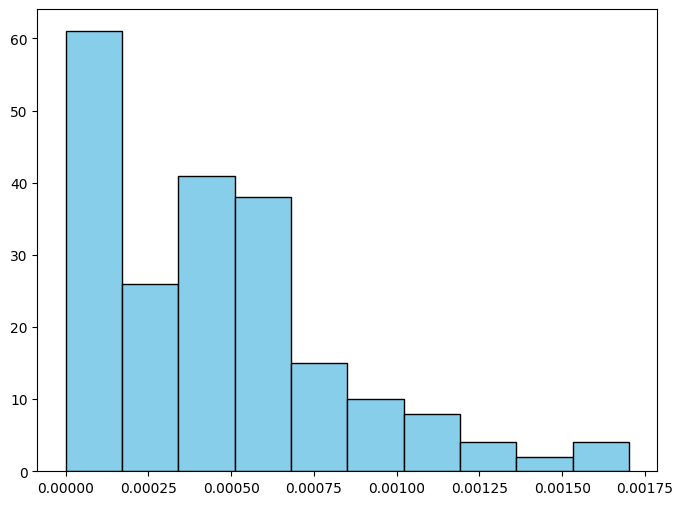

In [48]:
# ÌûàÏä§ÌÜ†Í∑∏Îû® Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(8, 6))
plt.hist(coverage, bins=10, color='skyblue', edgecolor='black')

In [49]:
recommended_items = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [50]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.8708133971291866

##### 1-2. CountVec + TF-IDF Rank Aggreation

In [51]:
recommended_items = []

for i in range(0, 209):
    test = content_recommender_rank(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [52]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.7129186602870813

##### 2. Word2Vec

In [73]:
recommended_items = []

for i in range(0, 209):
    test = recommend_similar_items(i, item_embeddings)
    recommended_items.extend(str(test[0]))


recommended_items = list(map(lambda x: int(x), recommended_items))

In [74]:
from metrics.coverage import get_coverage

n_items = len(item_embeddings)

get_coverage(recommended_items, n_items)

0.04784688995215311

#### INFERENCE

##### 1. CountVec + TF-IDF

In [55]:
case_1, _ = content_recommender(1, 3, sold_out)

In [56]:
df[df['product_board_id'].isin(case_1)]

id                                             option  option_price  \
7    8                                                            22770   
29  30                                             üç™ ÏÑ†ÌÉù üç™          4800   
45  46  Ï¥àÏΩî Ïò§Ìä∏Ïø†ÌÇ§ (-200Ïõê) BEST Ïä¥Ïù¥Ïø†ÌÇ§ (-300Ïõê) BEST Ìô©ÏπòÏ¶à Î¨¥ÏÑ§ÌÉï...         22600   

   category  gluten_free_tag high_protein_tag sugar_free_tag  vegan_tag  \
7       etc                                                   vegan_tag   
29   cookie  gluten_free_tag                                  vegan_tag   
45   cookie  gluten_free_tag                                  vegan_tag   

   ketogenic_tag                                              title      rate  \
7                  [Î™®ÎãêÏù¥ÎÑ§ÌïòÏö∞Ïä§] Í∏ÄÎ£®ÌÖêÌîÑÎ¶¨ 100% ÏåÄ ÏÜåÍ∏àÎπµ 5Í∞ú ÏÑ∏Ìä∏Íµ¨ÏÑ± [Î™®ÎãêÏù¥ÎÑ§ÌïòÏö∞Ïä§] ...  4.961538   
29                üç™ ÏÑ†ÌÉù üç™ ÎπÑÍ±¥ Í∏ÄÎ£®ÌÖê ÌîÑÎ¶¨ ÎßàÎì§Î†å 8Ï¢Ö (2P) Íµ¨Îñº Í∏ÄÎ£®ÌÖêÌîÑÎ¶¨, Ïò§ÏùºÌîÑÎ¶¨ Î¶¨Ïñº...       NaN   
45                Ï¥àÏΩî Ïò§Ìä∏Ïø†ÌÇ§ (-200Ïõê) BEST Ïä¥Ïù¥Ïø†ÌÇ§ (-300Ïõê) BEST Ìô©ÏπòÏ¶à Î¨¥ÏÑ§ÌÉï...  4.737705   

                                              content  \
7   Ìï≠ÏÉÅ Î®πÍ≥†ÏûàÎäî ÎπµÏù¥ÏóêÏöî..ÏÜçÌé∏ÌïòÍ≥† Ï¢ãÏïÑÏöî ÏûêÏ£ºÎ®πÎäîÍ±∞ÏóêÏöî..Í∑∏ÎÉ•Î®πÏñ¥ÎèÑ ÎßõÏûàÍ≥†Î≤ÑÌÑ∞Îßå Î∞ú...   
29                                                NaN   
45  ÌôÄÎ¶¨ Î∞îÏπòÏºÄ ÎåÄÎ∞ï ÎßõÏûàÏñ¥Ïöî Î¨¥Ï°±Í∂åÏûÑ..(ÏñºÎ®πÎ≥¥Îã§ Ìï¥ÎèôÌïúÍ≤å ÌíçÎØ∏ Ïß±Ïù¥ÎùºÏÑú Í∞†Ï†ÅÏúºÎ°ú Ìï¥...   

               title_with_spaces                       title_nouns_list  \
7   ÌÅ¨Î¶º Î≤ÑÌÑ∞ Ï¥àÏΩúÎ¶ø ÏπòÏ¶àÏºÄÏù¥ÌÅ¨ Î≤†Ïù¥Í∏Ä Ïø†ÌÇ§ ÏÑ§ÌÉï Ïä§ÏΩò  [ÌÅ¨Î¶º, Î≤ÑÌÑ∞, Ï¥àÏΩúÎ¶ø, ÏπòÏ¶àÏºÄÏù¥ÌÅ¨, Î≤†Ïù¥Í∏Ä, Ïø†ÌÇ§, ÏÑ§ÌÉï, Ïä§ÏΩò]   
29                   Ïø†ÌÇ§ Î∏åÎùºÏö∞Îãà ÎßàÎì§Î†å                        [Ïø†ÌÇ§, Î∏åÎùºÏö∞Îãà, ÎßàÎì§Î†å]   
45   ÌÅ¨Î¶º Î≤ÑÌÑ∞ ÎùºÏ¶àÎ≤†Î¶¨ ÏπòÏ¶àÏºÄÏù¥ÌÅ¨ Ïø†ÌÇ§ Î≤†Î¶¨ ÏÑ§ÌÉï Î≤à   [ÌÅ¨Î¶º, Î≤ÑÌÑ∞, ÎùºÏ¶àÎ≤†Î¶¨, ÏπòÏ¶àÏºÄÏù¥ÌÅ¨, Ïø†ÌÇ§, Î≤†Î¶¨, ÏÑ§ÌÉï, Î≤à]   

                                         soup  product_board_id  
7                     22770 etc    vegan_tag                  7  
29   4800 cookie gluten_free_tag   vegan_tag                 29  
45  22600 cookie gluten_free_tag   vegan_tag                 45

In [57]:
case_2, _ = content_recommender(100, 3, sold_out)

In [58]:
df[df['product_board_id'].isin(case_2)]

id                           option  option_price category  \
78    79                                           5390      etc   
120  121                                              0      etc   
169  172  Ï¥àÏΩîÌçºÏßÄ Ïø†ÌÇ§ ÎïÖÏΩ©ÏóêÌêÅÎãπ Ïø†ÌÇ§ ÎßêÏ∞®Îã§ÎØ∏ÏïÑ Ïø†ÌÇ§ Ïª§Ìîº Ïø†ÌÇ§          3500   cookie   

     gluten_free_tag high_protein_tag  sugar_free_tag  vegan_tag  \
78                                     sugar_free_tag  vegan_tag   
120  gluten_free_tag                                   vegan_tag   
169  gluten_free_tag                                   vegan_tag   

    ketogenic_tag                                              title  \
78                  nan Î¨¥Î£åÏ≤¥ÌóòÏó≠ÏãúÎÇò Ï†ÅÏãúÎÇò Í∑∏ÎÉ• ÏÜêÏúºÎ°ú ÎúØÏñ¥ Î®πÏñ¥ÎèÑ ÎßõÏûàÍ≥†Ïßà Ï¢ãÏùÄ ÏπòÏïÑÎ∞îÌÉÄ(Ïã¨ÏßÄ...   
120                 nan Îäò ÏÉùÍ∞ÅÎÇòÎäî ÎßõÏù¥ÏóêÏöî. ÍµøÍµø‚ô° Ïù¥Í±∞ ÏßÑÏßú ÎßõÏûàÏñ¥Ïöî‚Ä¶ÏπòÏïÑÎ∞îÌÉÄ Ï¢ãÏïÑÌïòÎäîÎç∞Îã§Î•∏Îç∞...   
169                Ï¥àÏΩîÌçºÏßÄ Ïø†ÌÇ§ ÎïÖÏΩ©ÏóêÌêÅÎãπ Ïø†ÌÇ§ ÎßêÏ∞®Îã§ÎØ∏ÏïÑ Ïø†ÌÇ§ Ïª§Ìîº Ïø†ÌÇ§ nan Ï¥àÏΩîÍ∞Ä Î∞ïÌòÄÏûàÏßÄÎßå ...   

         rate                                            content  \
78   5.000000  Î¨¥Î£åÏ≤¥ÌóòÏó≠ÏãúÎÇò Ï†ÅÏãúÎÇò Í∑∏ÎÉ• ÏÜêÏúºÎ°ú ÎúØÏñ¥ Î®πÏñ¥ÎèÑ ÎßõÏûàÍ≥†Ïßà Ï¢ãÏùÄ ÏπòÏïÑÎ∞îÌÉÄ(Ïã¨ÏßÄÏñ¥ ÎπÑÍ±¥ ...   
120  4.800000  Îäò ÏÉùÍ∞ÅÎÇòÎäî ÎßõÏù¥ÏóêÏöî. ÍµøÍµø‚ô° Ïù¥Í±∞ ÏßÑÏßú ÎßõÏûàÏñ¥Ïöî‚Ä¶ÏπòÏïÑÎ∞îÌÉÄ Ï¢ãÏïÑÌïòÎäîÎç∞Îã§Î•∏Îç∞Í±∞Î≥¥Îã§ Ìõ®...   
169  4.712644  Ï¥àÏΩîÍ∞Ä Î∞ïÌòÄÏûàÏßÄÎßå ÎßéÏù¥ Îã¨ÏßÄ ÏïäÏïÑÏÑú ÌïúÎ≤àÏóê Îã§Î®πÏóàÎÑ§ÏöîÎßõÏûàÍ≤å Ïûò Î®πÏóàÏäµÎãàÎã§~ ÎßêÏ∞®Ïø†ÌÇ§...   

      title_with_spaces           title_nouns_list  \
78      ÏπòÏïÑÎ∞îÌÉÄ ÌÅ¨Î¶º ÏãùÎπµ Î≤ÑÌÑ∞ Î≤à      [ÏπòÏïÑÎ∞îÌÉÄ, ÌÅ¨Î¶º, ÏãùÎπµ, Î≤ÑÌÑ∞, Î≤à]   
120       ÏÑ§ÌÉï ÏπòÏïÑÎ∞îÌÉÄ Ïø†ÌÇ§ ÏãùÎπµ         [ÏÑ§ÌÉï, ÏπòÏïÑÎ∞îÌÉÄ, Ïø†ÌÇ§, ÏãùÎπµ]   
169  ÏãùÎπµ ÍøÄÎßõ Î≤ÑÌÑ∞ Ïø†ÌÇ§ ÎßàÎì§Î†å ÏÑ§ÌÉï  [ÏãùÎπµ, ÍøÄÎßõ, Î≤ÑÌÑ∞, Ïø†ÌÇ§, ÎßàÎì§Î†å, ÏÑ§ÌÉï]   

                                         soup  product_board_id  
78       5390 etc   sugar_free_tag vegan_tag                 78  
120        0 etc gluten_free_tag   vegan_tag                120  
169  3500 cookie gluten_free_tag   vegan_tag                169

In [59]:
case_3, _ = content_recommender(200, 3, sold_out)

In [60]:
df[df['product_board_id'].isin(case_3)]

id                                     option  option_price category  \
96    97  Íµ¨ÏÑ±1 Íµ¨ÏÑ±2 Íµ¨ÏÑ±3 ÎùºÏ¶àÎ≤†Î¶¨ Ï¥àÏΩî Í∑∏ÎÇ≠ÏãúÏóê 4Í∞ú Ìå®ÏÖòÏΩîÏΩîÎÑõ Í∑∏ÎÇ≠ÏãúÏóê 4Í∞ú         48900     cake   
166  169                                                        0      etc   
175  178  Íµ¨ÏÑ±1 Íµ¨ÏÑ±2 Íµ¨ÏÑ±3 ÎùºÏ¶àÎ≤†Î¶¨ Ï¥àÏΩî Í∑∏ÎÇ≠ÏãúÏóê 8Í∞ú Ìå®ÏÖòÏΩîÏΩîÎÑõ Í∑∏ÎÇ≠ÏãúÏóê 8Í∞ú         65200     cake   

    gluten_free_tag high_protein_tag sugar_free_tag vegan_tag ketogenic_tag  \
96                                                                            
166                                                                           
175                                                                           

                                                 title      rate  \
96   Íµ¨ÏÑ±1 Íµ¨ÏÑ±2 Íµ¨ÏÑ±3 ÎùºÏ¶àÎ≤†Î¶¨ Ï¥àÏΩî Í∑∏ÎÇ≠ÏãúÏóê 4Í∞ú Ìå®ÏÖòÏΩîÏΩîÎÑõ Í∑∏ÎÇ≠ÏãúÏóê 4Í∞ú nan ...  4.538462   
166   nan Îî∏ÏïÑÎì§Ïù¥ Ï¢ãÏïÑÌïòÎäîÎπµÏù¥ÏóêÏöîÎßõÏûàÎã§Í≥† Ï¶êÍ≤®Î®πÎÑ§ÏöîÎ∞∞ÏÜ°Îπ†Î•¥Í≥†Ï¢ãÏïÑÏöî ÎßõÎèÑÎ¶¨ ÏûêÏ£º ÏãúÏºú...  4.692308   
175  Íµ¨ÏÑ±1 Íµ¨ÏÑ±2 Íµ¨ÏÑ±3 ÎùºÏ¶àÎ≤†Î¶¨ Ï¥àÏΩî Í∑∏ÎÇ≠ÏãúÏóê 8Í∞ú Ìå®ÏÖòÏΩîÏΩîÎÑõ Í∑∏ÎÇ≠ÏãúÏóê 8Í∞ú nan ...  4.615385   

                                               content title_with_spaces  \
96   Î∞∞ÏÜ°Îπ†Î•¥Í≥†  Î∞∞ÏÜ°ÎèÑÎπ†Î•¥Í≥†  Îã§ÏùåÏóê Îòê Íµ¨Îß§Ìï†Í≤åÏö© Îã®Í±∞ Îï°Í∏∏ Îïå Îï°Îï°ÏñºÎ†§ÏûàÎäîÍ±∞ Îπº Î®π...     ÎùºÏ¶àÎ≤†Î¶¨ ÌÅ¨Î¶º Ï¥àÏΩúÎ¶ø Î≤à   
166  Îî∏ÏïÑÎì§Ïù¥ Ï¢ãÏïÑÌïòÎäîÎπµÏù¥ÏóêÏöîÎßõÏûàÎã§Í≥† Ï¶êÍ≤®Î®πÎÑ§ÏöîÎ∞∞ÏÜ°Îπ†Î•¥Í≥†Ï¢ãÏïÑÏöî ÎßõÎèÑÎ¶¨ ÏûêÏ£º ÏãúÏºúÎ®πÏñ¥Ïó¨ Í±¥...           ÎùºÏ¶àÎ≤†Î¶¨ ÌÅ¨Î¶º   
175  ÏùºÎã® ÌÅ¨Í∏∞Îäî ÍµâÏû•Ìûà ÏûëÏïÑÏöî ÏÑ±Î∂ÑÏù¥ Í¥úÏ∞ÆÏïÑÏÑú Íµ¨Îß§ÌñàÎäîÎç∞ Ï†ÄÎäî Í∑∏ÎÉ• ÌïúÎ≤à Î®πÏñ¥Î≥∏Í±∏Î°ú Îßå...              ÎùºÏ¶àÎ≤†Î¶¨   

       title_nouns_list             soup  product_board_id  
96   [ÎùºÏ¶àÎ≤†Î¶¨, ÌÅ¨Î¶º, Ï¥àÏΩúÎ¶ø, Î≤à]  48900 cake                     96  
166          [ÎùºÏ¶àÎ≤†Î¶¨, ÌÅ¨Î¶º]       0 etc                    166  
175              [ÎùºÏ¶àÎ≤†Î¶¨]  65200 cake                    175

##### 2. Word2Vec

In [61]:
recommend_similar_items(3, item_embeddings)

[19, 24, 14]

#### SAVE

In [62]:
import pandas as pd
from datetime import datetime

In [63]:

query_item = df.index.values.repeat(3)

recommended_items = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))


score = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    score.extend(test[1])


score = list(map(lambda x: float(x), score))


rank = [1, 2, 3]*cosine_sim.shape[0]

recommendation_theme = ['similarity']*cosine_sim.shape[0]*3

model_version = ['bow-1+TF-IDF']*cosine_sim.shape[0]*3

created_at = [datetime.now()]*cosine_sim.shape[0]*3

modified_at = [datetime.now()]*cosine_sim.shape[0]*3

#### Ï∂îÏ≤ú Í≤∞Í≥º ÌÖåÏù¥Î∏î Ìè¨Îß∑
- query itemÏùÄ Ï∞úÏù¥ ÎàåÎ¶∞ ÏïÑÏù¥ÌÖúÏûÖÎãàÎã§.
- recommendation itemÏùÄ query ÏïÑÏù¥ÌÖú Îãπ 3Í∞úÎ•º Ï∂îÏ∂úÌï©ÎãàÎã§.
- Ïú†ÏÇ¨Ìïú recommendation itemÏù¥ ÏóÜÏùÑ Í≤ΩÏö∞ ÎûúÎç§Ìïú 3Í∞úÏùò Í≤∞Í≥ºÎ•º Ï∂îÏ≤úÌï©ÎãàÎã§.
- Ìè¨Îß∑Ïóê ÎßûÍ≤å Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÎßåÎì≠ÎãàÎã§. 

In [64]:
import pandas as pd
from datetime import datetime
data = {
    'query_item': query_item,
    'recommendation_item': recommended_items,
    'score': score,
    'rank': rank,
    'recommendation_theme': recommendation_theme,
    'model_version': model_version,
    'created_at': created_at,
    'modified_at': modified_at
}

recommendation_df = pd.DataFrame(data)


In [65]:
recommendation_df

query_item  recommendation_item     score  rank recommendation_theme  \
0             0                  189  0.729977     1           similarity   
1             0                   32  0.649314     2           similarity   
2             0                  198  0.581581     3           similarity   
3             1                   29  0.533355     1           similarity   
4             1                    7  0.516954     2           similarity   
..          ...                  ...       ...   ...                  ...   
622         207                   10  0.771317     2           similarity   
623         207                  169  0.711273     3           similarity   
624         208                    3  0.682648     1           similarity   
625         208                   19  0.599424     2           similarity   
626         208                  109  0.578521     3           similarity   

    model_version                 created_at                modified_at  
0    bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
1    bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
2    bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
3    bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
4    bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
..            ...                        ...                        ...  
622  bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
623  bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
624  bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
625  bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  
626  bow-1+TF-IDF 2024-11-04 16:54:53.667353 2024-11-04 16:54:53.667353  

[627 rows x 8 columns]

(array([ 88.,  68.,   1.,   5.,  14.,  79., 144., 126.,  56.,  46.]),
 array([0.1       , 0.18341641, 0.26683282, 0.35024922, 0.43366563,
        0.51708204, 0.60049845, 0.68391486, 0.76733126, 0.85074767,
        0.93416408]),
 <BarContainer object of 10 artists>)

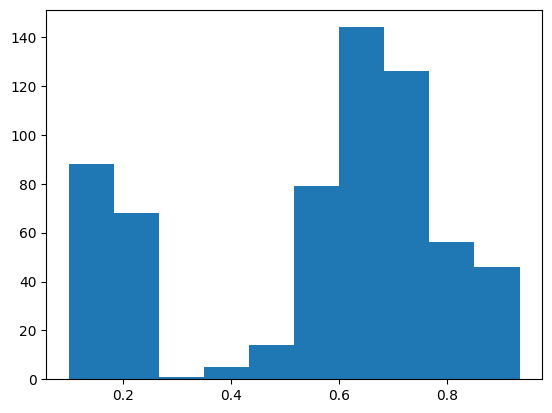

In [66]:
plt.hist(recommendation_df['score'])